In [6]:

# import the necessary packages
# from pyimagesearch import config
import tensorflow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import os
print("[INFO] loading dataset...")
f = open('/content/labels.txt', 'r')
rows = f.read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

for row in rows:
	# break the row into the filename and bounding box coordinates
    [filename, startX, startY] = row.split()
    # endX = startX + str(1)
    # endY = startY + str(1)

    image = cv2.imread("/content/"+filename) #/1.jpg #/content/31.jpg
    imagePath = "/content/"+filename
    (h, w) = image.shape[:2]
    startX = float(startX) 
    startY = float(startY) 
    # endX = float(endX) / w
    # endY = float(endY) / h
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

# # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY))
    filenames.append(filename)

[INFO] loading dataset...


In [7]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size = 0.10, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then

In [8]:
# load the VGG16 network, ensuring the head FC layers are left off
# vgg = tensorflow.keras.applications.ResNet50(weights="imagenet", include_top=False,
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(16, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(2, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# initialize the optimizer, compile the model, and show the model
opt = Adam(lr=1e-5) # replacement optimization algorithm for stochastic gradient descent for training deep learning models
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...") #BATCH_SIZE = 32 #NUM_EPOCHS = 25
H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets), batch_size=16, epochs=200, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Calculating accuracy
import imutils
import cv2
import os
import math
from google.colab.patches import cv2_imshow
# # loop over the images that we'll be testing using our bounding box
# # regression model
# for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
count_trues = 0
for t in testFilenames:
  imagePath = "/content/" + t
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
  preds = model.predict(image)[0]
  (startX, startY) = preds
  # check for distance:
  #1) # get image name from image path
  #2) #  get the respective corrdinates
  #3) # check to see ditance between predicted and actual centers is less than 0.05
  test = imagePath[::-1]
  index = test.index("/")
  image_name = test[:index]
  for r in rows:
    r = r.split()
    if t == r[0]:
      if math.sqrt((float(r[1]) - float(startX))**2 + (float(r[2]) - float(startY))**2) <= 0.05:
        count_trues+=1
        break

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  # scale the predicted bounding box coordinates based on the image
  # dimensions
  print((startX, startY))
  print(r[1],r[2])
  print(math.sqrt((float(r[1]) - float(startX))**2 + (float(r[2]) - float(startY))**2))
  startX = (startX * w)
  startY = (startY * h)
  # draw the predicted bounding box on the image

  # show the output image
  cv2.circle(image, (int(startX), int(startY)), 1, (255, 0, 0))
  cv2_imshow( image)
  cv2.waitKey(0)

print(count_trues)

imagepath/content/113.jpg
1/1 [==============================] - 1s 610ms/step
True
(0.507517, 0.50562054)
0.4714 0.8436
0.3399037395898979


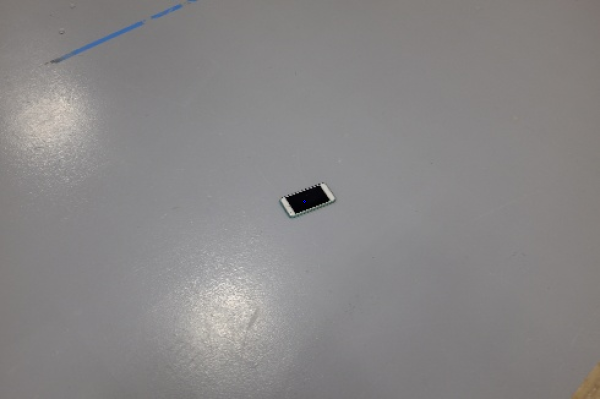

-1

In [7]:
'import imutils
import cv2
import os
import math
from google.colab.patches import cv2_imshow

# loop over the images that we'll be testing using our bounding box
# regression model
# for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
imagePath = input("imagepath")
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
  # make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY) = preds
# check for distance:
#1) get image name from image path
#2) get the respective corrdinates
#3) check to see ditance between predicted and actual centers is less than 0.05
test = imagePath[::-1]
index = test.index("/")
image_name = test[:index]
for r in rows:
	r = r.split()
	if image_name[::-1] == r[0]:
		if ((float(r[1]) - float(startX))**2 + (float(r[2]) - float(startY))**2) <= 0.0025:
			print("True")
		else:
			print("False")

	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
# draw the predicted bounding box on the image
print((startX, startY))
print(r[1],r[2])
print(math.sqrt((float(r[1]) - float(startX))**2 + (float(r[2]) - float(startY))**2))

startX = (startX * w)
startY = (startY * h)
# cv2.rectangle(image, (startX, startY), (startX+0.1,startX+0.1),(0, 255, 0), 2)
# show the output image
cv2.circle(image, (int(startX), int(startY)), 1, (255, 0, 0))
cv2_imshow( image)
cv2.waitKey(0)